In [1]:
#Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Scikit Learn
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
import seaborn as sns
from torchvision import datasets
from torchvision.transforms import ToTensor, transforms
from torch.utils.data import Dataset, DataLoader

from PIL import Image

##Custom made modules

#Dimensionality Reduction
from lda import LDA

#Classification
from bayes import bayes_nonparametric


/Users/chris/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:132: UserWarning: A NumPy version >=1.21.6 and <1.28.0 is required for this version of SciPy (detected version 1.21.5)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## Data Cleaning and Scaling
Some quick data transformation and splitting

In [2]:
# Load data
trainDataNP = np.load("fashion_train.npy")
testDataNP = np.load("fashion_test.npy")

# Split data into X and y arrays
X_train = trainDataNP[:, :-1]
y_train = trainDataNP[:, -1]
X_test = testDataNP[:, :-1]
y_test = testDataNP[:, -1]

# Scale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Dimenisonality reduction
Reducing feature dimensionalities through a custom made LDA model and SKlearns PCA

In [3]:
# Load custom made LDA from lda.py and project to 2 discriminant variables
lda2 = LDA(n_variables=2)
X_train_projected = lda2.fit_transform(X_train_scaled, y_train)
X_test_projected = lda2.transform(X_test_scaled)

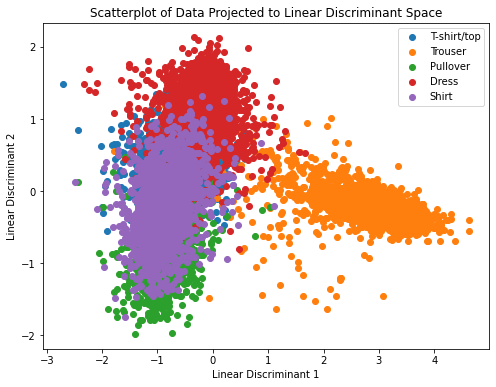

In [162]:
# Initializing class labels for plot
class_labels = np.unique(y_train)

label_names = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Shirt"
}

plt.figure(figsize=(8, 6))

# Creating a scatter plot
for idx, class_label in enumerate(class_labels):
    class_data = X_train_projected[y_train == class_label]
    fig = plt.scatter(class_data[:, 0], class_data[:, 1], label=label_names[class_label])

plt.xlabel('Linear Discriminant 1')
plt.ylabel('Linear Discriminant 2')
plt.title('Scatterplot of Data Projected to Linear Discriminant Space')
plt.legend()
plt.show()

In [4]:
# Load sklearn's PCA and project to 2 principal components
pca2 = PCA(n_components=2)
X_train_projected_pca = pca2.fit_transform(X_train_scaled)
X_test_projected_pca = pca2.transform(X_test_scaled)


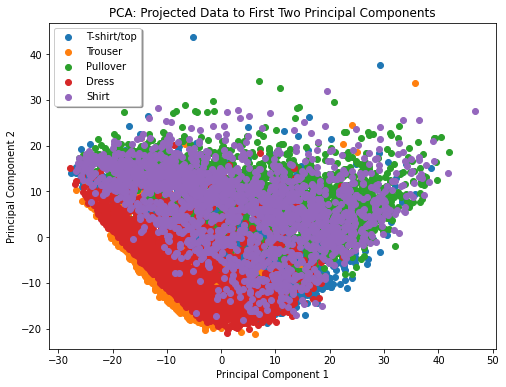

In [5]:
# Initializing class labels for plot
label_names = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Shirt"
}

plt.figure(figsize=(8, 6))

# Creating a scatter plot and plotting each class separately
for label in np.unique(y_train):
    indices = np.where(y_train == label)
    plt.scatter(X_train_projected_pca[indices, 0], X_train_projected_pca[indices, 1], label=label_names[label])

plt.title('PCA: Projected Data to First Two Principal Components')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(shadow=True)
    
plt.show()

## Classification
Classification through a custom made Naive Bayes Model and the further two methods being respcitvely a (CUSTOM?) KNN and a CNN model.

In [7]:
# Function created to be able to return best parameters with regards to the accuaracy of the Models below
def find_max_values(dictionary):
    if not dictionary:
        return None  # Return None for an empty dictionary

    max_value = max(dictionary.values())
    max_keys = [key for key, value in dictionary.items() if value == max_value]

    return max_keys

In [166]:
## Naive Bayes Classifier Model

# Here with two first Linear Discriminant variables
# For loop with the custom made bayes naive classifier, iterating over all the bandwidths, finding the optimal bandwith(s)
bandwiths = np.linspace(.01, 1, 50)
scores_bayes = {}
for bw in bandwiths:
    bayes = bayes_nonparametric(h = bw)
    bayes.fit(X_train_projected, y_train)
    y_pred = bayes.predict(X_test_projected)
    scores_bayes[round(bw, 2)] = accuracy_score(y_test, y_pred)

resultBayes = find_max_values(scores_bayes)
if resultBayes:
    print(f"The bandwidth(s) with maximum value(s) in the dictionary is/are {resultBayes} with a value of {scores_bayes[resultBayes[0]]}")
else:
    print("The dictionary is empty.")

The bandwidth(s) with maximum value(s) in the dictionary is/are [0.15, 0.35] with a value of 0.7292


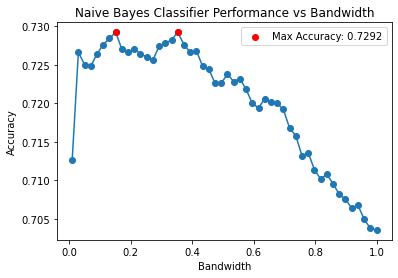

The bandwidth(s) with maximum value(s) in the dictionary is/are [(0.15,), (0.35,)] with a value of 0.7292


In [205]:
# Naive Bayes Classifier Model
bandwidths = np.linspace(0.01, 1, 50)
scores_bayes = {}

for bw in bandwidths:
    bayes = bayes_nonparametric(h=bw)
    bayes.fit(X_train_projected, y_train)
    y_pred = bayes.predict(X_test_projected)
    scores_bayes[tuple([round(bw, 2)])] = accuracy_score(y_test, y_pred)

resultBayes = find_max_values(scores_bayes)

if resultBayes:
    max_bandwidths = resultBayes

    # Get the maximum accuracy for labeling the plot
    max_accuracy = scores_bayes[max_bandwidths[0]]

    # Find other bandwidths with very close accuracy
    close_bandwidths = [bw for bw in bandwidths if abs(scores_bayes[tuple([round(bw, 2)])] - max_accuracy) < 1e-4]

    # Visualize the results
    plt.plot(bandwidths, list(scores_bayes.values()), marker='o', linestyle='-')
    plt.scatter(close_bandwidths, [max_accuracy] * len(close_bandwidths), color='red', label=f'Max Accuracy: {max_accuracy:.4f}', zorder=5)
    plt.title('Naive Bayes Classifier Performance vs Bandwidth')
    plt.xlabel('Bandwidth')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    print(f"The bandwidth(s) with maximum value(s) in the dictionary is/are {max_bandwidths} with a value of {max_accuracy:.4f}")
else:
    print("The dictionary is empty.")

In [ ]:
## K nearest neighbours model

# On whole dataset:
scores_KNN_ovr = {}

for k in range (1,102, 2):
    # Create a pipeline with PCA and KNN
    pipeline = Pipeline([
    ('scaler', StandardScaler()), #Scaler in Pipeline to scale after each fold
    ('knn', KNeighborsClassifier(n_neighbors=k))]) # Use KNN classifier

    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5)  # 5-fold cross-validation
    scores_KNN_ovr[k] = round(np.mean(cv_scores), 4)
    print("Cross-Validation Scores for k =", k, ":", cv_scores)
    print("Mean Accuracy for k =", k, ":", round(cv_scores.mean(), 4))


resultKNNovr = find_max_values(scores_KNN_ovr)
if resultKNNovr:
    print(f"The k neighbour(s) with maximum value(s) in the dictionary is/are {resultKNNovr} with a value of {scores_KNN_ovr[resultKNNovr[0]]}")
else:
    print("The dictionary is empty.")

In [252]:
#Create the final pipeline with the best k
final_pipelineOvr = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=resultKNNovr[0]))
])

# Train the final model on the entire training dataset
final_pipelineOvr.fit(X_train, y_train)

# Predict on the test data
y_pred = final_pipelineOvr.predict(X_test)

# Evaluate the performance on the test data
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy in X_test for optimal k = {resultKNNovr[0]}: {test_accuracy}")

Test Accuracy in X_test for optimal k = 5: 0.8222


In [6]:
# With LDA as dimenisonality reduction

# Load custom made LDA from lda.py and project to respectively 3 and 4 (max) discriminant variables
lda3 = LDA(n_variables=3)
X_train_projected_3 = lda3.fit_transform(X_train_scaled, y_train)
X_test_projected_3 = lda3.transform(X_test_scaled)

lda4 = LDA(n_variables=4)
X_train_projected_4 = lda4.fit_transform(X_train_scaled, y_train)
X_test_projected_4 = lda4.transform(X_test_scaled)

In [172]:
## K nearest neighbours model

# LDA 2
scores_KNN_lda2 = {}

for k in range (1,102, 2):
    # Create a pipeline with PCA and KNN
    pipeline = Pipeline([
    ('scaler', StandardScaler()), #Scaler in Pipeline to scale after each fold
    ('lda', lda2), # Apply PCA for dimensionality reduction
    ('knn', KNeighborsClassifier(n_neighbors=k))]) # Use KNN classifier

    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5)  # 5-fold cross-validation
    scores_KNN_lda2[k] = round(np.mean(cv_scores), 4)
    print("Cross-Validation Scores for k =", k, ":", cv_scores)
    print("Mean Accuracy for k =", k, ":", round(cv_scores.mean(), 4))


resultKNNlda2 = find_max_values(scores_KNN_lda2)
if resultKNNlda2:
    print(f"The k neighbour(s) with maximum value(s) in the dictionary is/are {resultKNNlda2} with a value of {scores_KNN_lda2[resultKNNlda2[0]]}")
else:
    print("The dictionary is empty.")

Cross-Validation Scores for k = 1 : [0.6705 0.648  0.6705 0.675  0.6725]
Mean Accuracy for k = 1 : 0.6673
Cross-Validation Scores for k = 3 : [0.7085 0.6995 0.7135 0.7075 0.7005]
Mean Accuracy for k = 3 : 0.7059
Cross-Validation Scores for k = 5 : [0.725  0.7095 0.7305 0.724  0.72  ]
Mean Accuracy for k = 5 : 0.7218
Cross-Validation Scores for k = 7 : [0.7365 0.7225 0.742  0.7385 0.7185]
Mean Accuracy for k = 7 : 0.7316
Cross-Validation Scores for k = 9 : [0.734  0.7245 0.743  0.7415 0.725 ]
Mean Accuracy for k = 9 : 0.7336
Cross-Validation Scores for k = 11 : [0.7445 0.725  0.7395 0.7415 0.724 ]
Mean Accuracy for k = 11 : 0.7349
Cross-Validation Scores for k = 13 : [0.744  0.731  0.7415 0.746  0.729 ]
Mean Accuracy for k = 13 : 0.7383
Cross-Validation Scores for k = 15 : [0.734  0.7345 0.7435 0.744  0.7305]
Mean Accuracy for k = 15 : 0.7373
Cross-Validation Scores for k = 17 : [0.736  0.7325 0.74   0.746  0.7325]
Mean Accuracy for k = 17 : 0.7374
Cross-Validation Scores for k = 19 : [

In [221]:
#Create the final pipeline with the best k
final_pipeline2 = Pipeline([
    ('scaler', StandardScaler()),
    ('lda', lda2),
    ('knn', KNeighborsClassifier(n_neighbors=resultKNNlda2[0]))
])

# Train the final model on the entire training dataset
final_pipeline2.fit(X_train, y_train)

# Predict on the test data
y_pred = final_pipeline2.predict(X_test)

# Evaluate the performance on the test data
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy in X_test for optimal k = {resultKNNlda2[0]}: {test_accuracy}")

Test Accuracy in X_test for optimal k = 61: 0.734


In [173]:
## K nearest neighbours model

# LDA 3
scores_KNN_lda3 = {}

for k in range (1,102,2):
    # Create a pipeline with PCA and KNN
    pipeline = Pipeline([
    ('scaler', StandardScaler()), #Scaler in Pipeline to scale after each fold
    ('lda', lda3), # Apply PCA for dimensionality reduction
    ('knn', KNeighborsClassifier(n_neighbors=k))]) # Use KNN classifier

    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5)  # 5-fold cross-validation
    scores_KNN_lda3[k] = round(np.mean(cv_scores), 4)
    print("Cross-Validation Scores for k =", k, ":", cv_scores)
    print("Mean Accuracy for k =", k, ":", round(cv_scores.mean(), 4))


resultKNNlda3 = find_max_values(scores_KNN_lda3)
if resultKNNlda3:
    print(f"The k neighbour(s) with maximum value(s) in the dictionary is/are {resultKNNlda3} with a value of {scores_KNN_lda3[resultKNNlda3[0]]}")
else:
    print("The dictionary is empty.")

Cross-Validation Scores for k = 1 : [0.714  0.722  0.7335 0.743  0.7295]
Mean Accuracy for k = 1 : 0.7284
Cross-Validation Scores for k = 3 : [0.7465 0.742  0.7535 0.7675 0.747 ]
Mean Accuracy for k = 3 : 0.7513
Cross-Validation Scores for k = 5 : [0.7645 0.758  0.7635 0.7775 0.7615]
Mean Accuracy for k = 5 : 0.765
Cross-Validation Scores for k = 7 : [0.7715 0.759  0.77   0.782  0.773 ]
Mean Accuracy for k = 7 : 0.7711
Cross-Validation Scores for k = 9 : [0.769  0.7615 0.776  0.7775 0.774 ]
Mean Accuracy for k = 9 : 0.7716
Cross-Validation Scores for k = 11 : [0.7725 0.7665 0.776  0.7855 0.7765]
Mean Accuracy for k = 11 : 0.7754
Cross-Validation Scores for k = 13 : [0.774  0.768  0.778  0.7845 0.7735]
Mean Accuracy for k = 13 : 0.7756
Cross-Validation Scores for k = 15 : [0.778  0.7655 0.781  0.785  0.7765]
Mean Accuracy for k = 15 : 0.7772
Cross-Validation Scores for k = 17 : [0.7775 0.769  0.783  0.783  0.774 ]
Mean Accuracy for k = 17 : 0.7773
Cross-Validation Scores for k = 19 : [0

In [224]:
#Create the final pipeline with the best k
final_pipeline3 = Pipeline([
    ('scaler', StandardScaler()),
    ('lda', lda3),
    ('knn', KNeighborsClassifier(n_neighbors=resultKNNlda3[0]))
])

# Train the final model on the entire training dataset
final_pipeline3.fit(X_train, y_train)

# Predict on the test data
y_pred = final_pipeline3.predict(X_test)

# Evaluate the performance on the test data
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy in X_test for optimal k = {resultKNNlda3[0]}: {test_accuracy}")

# AND

#Create the final pipeline with the best k
final_pipeline3 = Pipeline([
    ('scaler', StandardScaler()),
    ('lda', lda3),
    ('knn', KNeighborsClassifier(n_neighbors=resultKNNlda3[1]))
])

# Train the final model on the entire training dataset
final_pipeline3.fit(X_train, y_train)

# Predict on the test data
y_pred = final_pipeline3.predict(X_test)

# Evaluate the performance on the test data
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy in X_test for optimal k = {resultKNNlda3[1]}: {test_accuracy}")

Test Accuracy in X_test for optimal k = 41: 0.7784
Test Accuracy in X_test for optimal k = 87: 0.7798


In [174]:
## K nearest neighbours model

# LDA 4
scores_KNN_lda4 = {}

for k in range (1,102, 2):
    # Create a pipeline with PCA and KNN
    pipeline = Pipeline([
    ('scaler', StandardScaler()), #Scaler in Pipeline to scale after each fold
    ('lda', lda4), # Apply PCA for dimensionality reduction
    ('knn', KNeighborsClassifier(n_neighbors=k))]) # Use KNN classifier

    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5)  # 5-fold cross-validation
    scores_KNN_lda4[k] = round(np.mean(cv_scores), 4)
    print("Cross-Validation Scores for k =", k, ":", cv_scores)
    print("Mean Accuracy for k =", k, ":", round(cv_scores.mean(), 4))


resultKNNlda4 = find_max_values(scores_KNN_lda4)
if resultKNNlda4:
    print(f"The k neighbour(s) with maximum value(s) in the dictionary is/are {resultKNNlda4} with a value of {scores_KNN_lda4[resultKNNlda4[0]]}")
else:
    print("The dictionary is empty.")

Cross-Validation Scores for k = 1 : [0.777  0.7765 0.775  0.763  0.7645]
Mean Accuracy for k = 1 : 0.7712
Cross-Validation Scores for k = 3 : [0.807  0.7975 0.806  0.796  0.792 ]
Mean Accuracy for k = 3 : 0.7997
Cross-Validation Scores for k = 5 : [0.812  0.806  0.8115 0.7995 0.808 ]
Mean Accuracy for k = 5 : 0.8074
Cross-Validation Scores for k = 7 : [0.8165 0.812  0.8145 0.809  0.807 ]
Mean Accuracy for k = 7 : 0.8118
Cross-Validation Scores for k = 9 : [0.8125 0.8145 0.814  0.8115 0.8075]
Mean Accuracy for k = 9 : 0.812
Cross-Validation Scores for k = 11 : [0.813  0.819  0.8175 0.8155 0.814 ]
Mean Accuracy for k = 11 : 0.8158
Cross-Validation Scores for k = 13 : [0.8155 0.8165 0.814  0.816  0.813 ]
Mean Accuracy for k = 13 : 0.815
Cross-Validation Scores for k = 15 : [0.8165 0.8205 0.817  0.8175 0.8155]
Mean Accuracy for k = 15 : 0.8174
Cross-Validation Scores for k = 17 : [0.8185 0.819  0.8165 0.8145 0.8115]
Mean Accuracy for k = 17 : 0.816
Cross-Validation Scores for k = 19 : [0.8

In [251]:
#Create the final pipeline with the best k
final_pipeline4 = Pipeline([
    ('scaler', StandardScaler()),
    ('lda', lda4),
    ('knn', KNeighborsClassifier(n_neighbors=resultKNNlda4[0]))
])

# Train the final model on the entire training dataset
final_pipeline4.fit(X_train, y_train)

# Predict on the test data
y_predlda = final_pipeline4.predict(X_test)

# Evaluate the performance on the test data
test_accuracy = accuracy_score(y_test, y_predlda)
print(f"Test Accuracy in X_test for optimal k = {resultKNNlda4[0]}: {test_accuracy}")

Test Accuracy in X_test for optimal k = 43: 0.8158


In [6]:
## K nearest neighbours model

# With PCA as dimenisonality reduction
scores_KNN_pca = {}

for k in range (1,102, 2):
    # Create a pipeline with PCA and KNN
    pipeline = Pipeline([
    ('scaler', StandardScaler()), #Scaler in Pipeline to scale after each fold
    ('pca', PCA(n_components=0.95)), # Apply PCA for dimensionality reduction
    ('knn', KNeighborsClassifier(n_neighbors=k))]) # Use KNN classifier

    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5)  # 5-fold cross-validation
    scores_KNN_pca[k] = round(np.mean(cv_scores), 4)
    print("Cross-Validation Scores for k =", k, ":", cv_scores)
    print("Mean Accuracy for k =", k, ":", round(cv_scores.mean(), 4))


resultKNNpca = find_max_values(scores_KNN_pca)
if resultKNNpca:
    print(f"The k neighbour(s) with maximum value(s) in the dictionary is/are {resultKNNpca} with a value of {scores_KNN_pca[resultKNNpca[0]]}")
else:
    print("The dictionary is empty.")

Cross-Validation Scores for k = 1 : [0.823  0.8185 0.8195 0.806  0.8175]
Mean Accuracy for k = 1 : 0.8169
Cross-Validation Scores for k = 3 : [0.833  0.833  0.8335 0.8265 0.8355]
Mean Accuracy for k = 3 : 0.8323
Cross-Validation Scores for k = 5 : [0.8295 0.8355 0.8395 0.8365 0.835 ]
Mean Accuracy for k = 5 : 0.8352
Cross-Validation Scores for k = 7 : [0.829  0.8395 0.837  0.838  0.8305]
Mean Accuracy for k = 7 : 0.8348
Cross-Validation Scores for k = 9 : [0.834  0.835  0.8425 0.8375 0.837 ]
Mean Accuracy for k = 9 : 0.8372
Cross-Validation Scores for k = 11 : [0.8355 0.8325 0.834  0.8345 0.836 ]
Mean Accuracy for k = 11 : 0.8345
Cross-Validation Scores for k = 13 : [0.832  0.8355 0.829  0.834  0.837 ]
Mean Accuracy for k = 13 : 0.8335
Cross-Validation Scores for k = 15 : [0.8385 0.829  0.835  0.8365 0.8305]
Mean Accuracy for k = 15 : 0.8339
Cross-Validation Scores for k = 17 : [0.8345 0.8315 0.8325 0.8335 0.8315]
Mean Accuracy for k = 17 : 0.8327
Cross-Validation Scores for k = 19 : [

NameError: name 'find_max_values' is not defined

In [8]:
resultKNNpca = find_max_values(scores_KNN_pca)
if resultKNNpca:
    print(f"The k neighbour(s) with maximum value(s) in the dictionary is/are {resultKNNpca} with a value of {scores_KNN_pca[resultKNNpca[0]]}")
else:
    print("The dictionary is empty.")

The k neighbour(s) with maximum value(s) in the dictionary is/are [9] with a value of 0.8372


In [11]:
#Create the final pipeline with the best k
final_pipelinePca = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95)),
    ('knn', KNeighborsClassifier(n_neighbors=resultKNNpca[0]))
])

# Train the final model on the entire training dataset
final_pipelinePca.fit(X_train, y_train)

# Predict on the test data
y_predPca = final_pipelinePca.predict(X_test)

# Evaluate the performance on the test data
test_accuracy = accuracy_score(y_test, y_predPca)
print(f"Test Accuracy in X_test for optimal k = {resultKNNpca[0]}: {test_accuracy}")

# Get other metrics
classwise_metrics = classification_report(y_test, y_predPca, target_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Shirt'])

print(f'Statistics for KNN with PCA and k = {resultKNNpca[0]}:')
print(classwise_metrics)

Test Accuracy in X_test for optimal k = 9: 0.8248
Statistics for KNN with PCA and k = 9:
              precision    recall  f1-score   support

 T-shirt/top       0.76      0.84      0.80      1000
     Trouser       0.99      0.95      0.97      1000
    Pullover       0.81      0.82      0.82      1000
       Dress       0.90      0.90      0.90      1000
       Shirt       0.67      0.61      0.64      1000

    accuracy                           0.82      5000
   macro avg       0.83      0.82      0.82      5000
weighted avg       0.83      0.82      0.82      5000



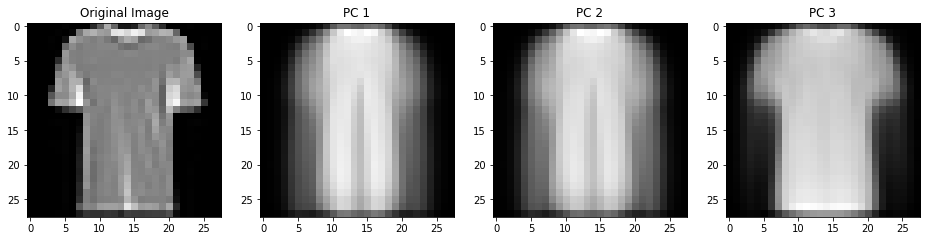

In [28]:
import seaborn as sns


# Extract one example image
example_index = 0  # Replace with the index of the image you want to visualize
example_image = X_train[example_index, :]

# Standardize the data (important for PCA)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Apply PCA with the correct number of components
n_components = min(X_train.shape[0], X_train.shape[1])
pca = PCA(n_components=n_components)
principal_components = pca.fit_transform(X_train_scaled)

# Visualize the impact of each principal component on the example image
fig, axs = plt.subplots(1, 4, figsize=(16, 4))

# Plot the original image
axs[0].imshow(example_image.reshape(28, 28), cmap='gray')
axs[0].set_title('Original Image')

# Plot reconstructed images based on each principal component
for i in range(3):
    # Construct the reconstructed image by using the inverse transform of the i-th principal component
    reconstructed_image = np.dot(principal_components[example_index, :i+1], pca.components_[:i+1, :])
    reconstructed_image = scaler.inverse_transform(reconstructed_image.reshape(1, -1)).reshape(28, 28)
    
    axs[i + 1].imshow(reconstructed_image, cmap='gray')
    axs[i + 1].set_title(f'PC {i + 1}')

plt.show()

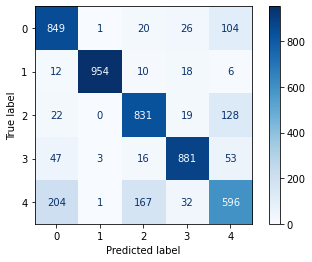

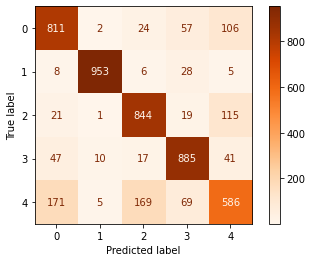

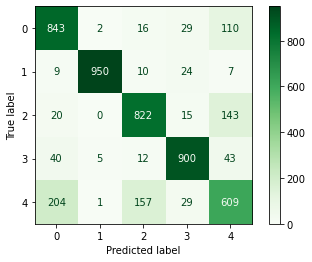

In [253]:
displ = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred), display_labels=label_names)
displ.plot(cmap='Blues')

displ = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_predlda), display_labels=label_names)
displ.plot(cmap='Oranges')

displ = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_predPca), display_labels=label_names)
displ.plot(cmap='Greens')

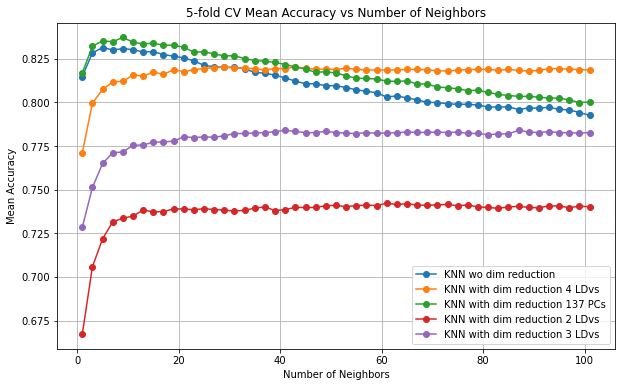

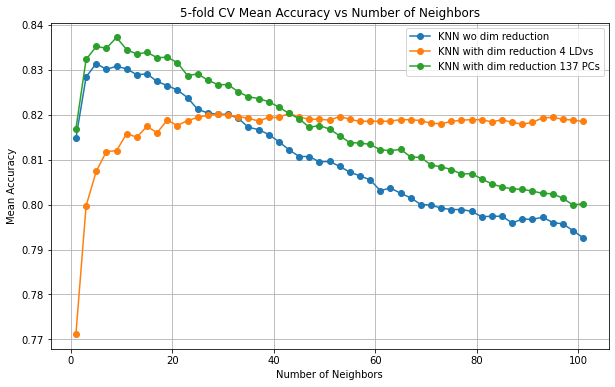

In [227]:
## Plotting of all models above

# Combine dictionaries into a list for iteration
all_dicts = {'KNN wo dim reduction': scores_KNN_ovr,
             'KNN with dim reduction 4 LDvs': scores_KNN_lda4, 
             'KNN with dim reduction 137 PCs': scores_KNN_pca,
             'KNN with dim reduction 2 LDvs': scores_KNN_lda2, 
             'KNN with dim reduction 3 LDvs': scores_KNN_lda3}


# Plotting
plt.figure(figsize=(10, 6))
for label, d in all_dicts.items():
    x_vals = list(d.keys())
    y_vals = list(d.values())
    plt.plot(x_vals, y_vals, marker='o', label=label)

plt.title('5-fold CV Mean Accuracy vs Number of Neighbors')
plt.xlabel('Number of Neighbors')
plt.ylabel('Mean Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Combine dictionaries into a list for iteration
all_dicts = {'KNN wo dim reduction': scores_KNN_ovr, 
             'KNN with dim reduction 4 LDvs': scores_KNN_lda4, 
             'KNN with dim reduction 137 PCs': scores_KNN_pca}



## Plotting of relevant models above

# Plotting
plt.figure(figsize=(10, 6))
for label, d in all_dicts.items():
    x_vals = list(d.keys())
    y_vals = list(d.values())
    plt.plot(x_vals, y_vals, marker='o', label=label)

plt.title('5-fold CV Mean Accuracy vs Number of Neighbors')
plt.xlabel('Number of Neighbors')
plt.ylabel('Mean Accuracy')
plt.legend()
plt.grid(True)
plt.show()

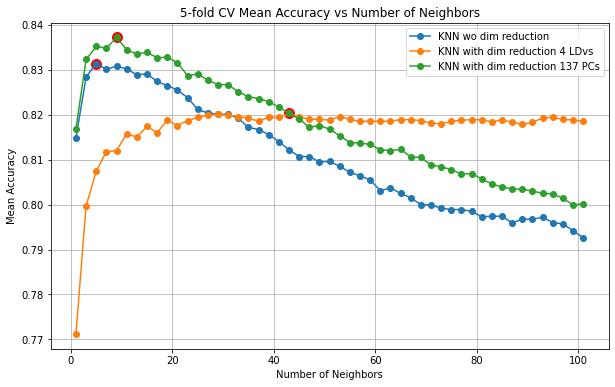

In [257]:
# Combine dictionaries into a list for iteration
all_dicts = {'KNN wo dim reduction': scores_KNN_ovr, 
             'KNN with dim reduction 4 LDvs': scores_KNN_lda4, 
             'KNN with dim reduction 137 PCs': scores_KNN_pca}

# Plotting
plt.figure(figsize=(10, 6))
for label, d in all_dicts.items():
    x_vals = list(d.keys())
    y_vals = list(d.values())
    
    # Find the index of the maximum accuracy
    max_index = y_vals.index(max(y_vals))
    
    # Plot the line
    plt.plot(x_vals, y_vals, marker='o', label=label)
    
    # Mark the point with the highest mean accuracy with a red dot
    plt.scatter(x_vals[max_index], y_vals[max_index], color='red', s=100)

plt.title('5-fold CV Mean Accuracy vs Number of Neighbors')
plt.xlabel('Number of Neighbors')
plt.ylabel('Mean Accuracy')
plt.legend()
plt.grid(True)
plt.show()